## Imports

In [1]:
import os
import json
import random
import torch
import torchaudio
from kan import KAN
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torchaudio.transforms as T

import librosa
import matplotlib.pyplot as plt

from tqdm import tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Plotting

In [3]:
def plot_waveform(waveform, sr, title="Waveform", ax=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    if ax is None:
        _, ax = plt.subplots(num_channels, 1)
    ax.plot(time_axis, waveform[0], linewidth=1)
    ax.grid(True)
    ax.set_xlim([0, time_axis[-1]])
    ax.set_title(title)

def plot_mono_waveform(waveform, sr, title="Waveform", ax=None):
    waveform = waveform.numpy()

    num_channels, num_frames = 1, waveform.shape[0]
    time_axis = torch.arange(0, num_frames) / sr

    if ax is None:
        _, ax = plt.subplots(num_channels, 1)
    ax.plot(time_axis, waveform, linewidth=1)
    ax.grid(True)
    ax.set_xlim([0, time_axis[-1]])
    ax.set_title(title)


def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")


def plot_fbank(fbank, title=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Filter bank")
    axs.imshow(fbank, aspect="auto")
    axs.set_ylabel("frequency bin")
    axs.set_xlabel("mel bin")

In [4]:
import os
print(os.path.isfile('./data/Dipco/audio/dev/S10_P29.wav'))

True


Shape of waveform: torch.Size([1, 28809500])
Sample rate: 16000


Shape of spectrogram: torch.Size([1, 128, 28135])


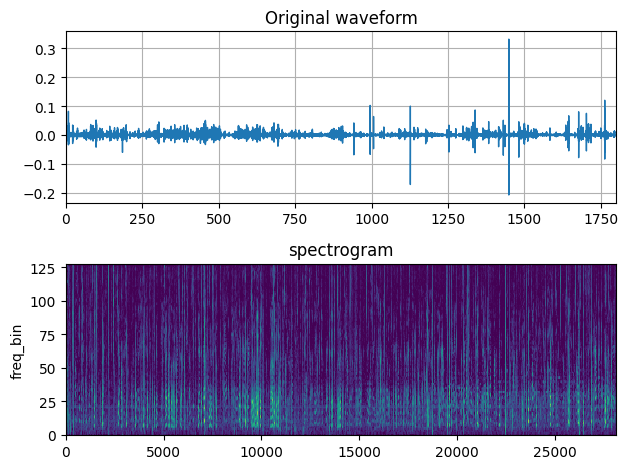

In [5]:
import torchaudio

# Load the audio file
waveform, sample_rate = torchaudio.load('./data/Dipco/audio/dev/S02_P05.wav')

# Print the shape of the waveform tensor
print("Shape of waveform:", waveform.shape)

# Print the sample rate
print("Sample rate:", sample_rate)

spectrogram = T.MelSpectrogram(
            sample_rate=sample_rate,
            n_fft=2048,
            n_mels=128
        )
# Perform transform
spec = spectrogram(waveform)
print('Shape of spectrogram:', spec.shape)
fig, axs = plt.subplots(2, 1)
plot_waveform(waveform, sample_rate, title="Original waveform", ax=axs[0])
plot_spectrogram(spec[0], title="spectrogram", ax=axs[1])
fig.tight_layout()

## Data Loading

In [6]:
class DiPCoSeparationDataset(Dataset):
    def __init__(self, root_dir, session_ids, version='dev', 
                 segment_length=3, sr=16000, max_pairs=10000, 
                 transform=True,*,n_mels=128, n_fft=1024, hop_length=64, mel_reduction='None'):
        self.sr = sr
        self.segment_samples = int(sr * segment_length)
        self.n_mels = n_mels

        self.mel_reduction = mel_reduction
        self.pairs = []
        self.session_data = {}

        self.mel_transform = T.MelSpectrogram(
            sample_rate=sr,
            n_fft=n_fft,
            n_mels=n_mels,
            # hop_length=hop_length
        )

        for session_id in session_ids:
            trans_path = os.path.join(root_dir, 'transcriptions', version, f'{session_id}.json')
            with open(trans_path, 'r') as f:
                session_trans = json.load(f)
            
            session_dict = {}
            # Get unique speakers for session
            for utt in session_trans:
                if utt['speaker_id'] not in session_dict:
                    speaker_id = utt['speaker_id']
                    session_dict[speaker_id] = []

            for speaker_id in session_dict.keys():
                audio_path = os.path.join(root_dir, 'audio', version,
                                        f"{session_id}_{speaker_id}.wav")
                
                speaker_audio = self._load_full_audio(audio_path)
                # plot_mono_waveform(speaker_audio, sr)
                # plt.show()
                speaker_audio_len = speaker_audio.shape[0]
                max_start = speaker_audio_len - self.segment_samples
                # print()
                session_dict[speaker_id].extend([speaker_audio[start:start + self.segment_samples] for start in range(0, max_start, sr * segment_length)])

            self.session_data[session_id] = session_dict

            print(f'Loading {session_id}, unique speaker_ids: {session_dict.keys()}')

            for speaker_i in list(session_dict.keys())[:-1]:
                for speaker_j in list(session_dict.keys())[1:]:
                    # print(speaker_i, speaker_j, len(session_dict[speaker_i]))
                    for speaker_i_audio in session_dict[speaker_i]:
                        for speaker_j_audio in session_dict[speaker_j]:
                            # print(speaker_i, speaker_j, speaker_i_audio, speaker_j_audio)
                            if transform:
                                mel1 = self._to_mel(speaker_i_audio)
                                mel2 = self._to_mel(speaker_j_audio)
                            else:
                                mel1 = speaker_i_audio
                                mel2 = speaker_j_audio
                            
                            mixed = (speaker_i_audio + speaker_j_audio).clamp(-1, 1)
                            if transform:
                                mixed_mel = self._to_mel(mixed)
                            else:
                                mixed_mel = mixed.unsqueeze(0)
                                mel1 = mel1.unsqueeze(0)
                                mel2 = mel2.unsqueeze(0)
                            self.pairs.append(
                                (mixed_mel, 
                                torch.stack([mel1, mel2]))
                            )
                            if len(self.pairs) >= max_pairs:
                                break
                        if len(self.pairs) >= max_pairs:
                            break
                    if len(self.pairs) >= max_pairs:
                            break
                if len(self.pairs) >= max_pairs:
                    break

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        return self.pairs[idx]

    def _load_full_audio(self, path):
        waveform, orig_sr = torchaudio.load(path)
        if orig_sr != self.sr:
            resampler = torchaudio.transforms.Resample(orig_sr, self.sr)
            waveform = resampler(waveform)
        waveform = torch.mean(waveform, dim=0)  # Convert to mono
        return waveform
    

    def _to_mel(self, audio):
        mel = self.mel_transform(audio)  # [1, n_mels, T]
        # if self.mel_reduction == 'mean':
        #     return mel.mean(dim=-1).squeeze(0)  # [n_mels]
        # elif self.mel_reduction == 'flatten':
        #     return mel.squeeze(0).flatten() # [n_mels * T]
        # else:
        return mel # [n_mels, T]

In [19]:
dataset = DiPCoSeparationDataset(
    root_dir='./data/Dipco/',
    session_ids=['S02'],#, 'S04', 'S05', 'S09', 'S10'],
    segment_length=3,
    mel_reduction='mean',
    max_pairs=100,
    n_mels= 128*2,
    n_fft=512,
)
train_loader = DataLoader(dataset, batch_size=64, shuffle=True)
len(dataset.pairs), dataset.pairs[0][0].shape, len(train_loader)

c:\Users\chaud\Desktop\!Back_this_folder!\College\Masters\Spring 2025\Neural Networks Deep Learning\Final Project\.venv\lib\site-packages\torchaudio\functional\functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (257) may be set too low.
  warnings.warn(


Loading S02, unique speaker_ids: dict_keys(['P05', 'P06', 'P07', 'P08'])


(100, torch.Size([256, 188]), 2)

## Pure KAN implementation

In [8]:
class SeparationKAN(nn.Module):
    def __init__(self, input_size=128, time_steps=188, latent_dim=16,):
        super().__init__()
        # Add time dimension handling
        self.input_size = input_size
        self.time_steps = time_steps
        flattened_size = input_size * time_steps
        
        # Modified architecture
        self.encoder = KAN(width=[flattened_size, 16, latent_dim], auto_save=False, symbolic_enabled=False)
        self.decoder1 = KAN(width=[latent_dim//2, 16, flattened_size], auto_save=False, symbolic_enabled=False)
        self.decoder2 = KAN(width=[latent_dim//2, 16, flattened_size], auto_save=False, symbolic_enabled=False)

    def forward(self, x):
        # Input shape: [batch, 1, n_mels=128, time=188]
        batch_size = x.shape[0]
        
        # Flatten spectrogram to 2D: [batch, features]
        x_flat = x.view(batch_size, -1)
        
        latent = self.encoder(x_flat)
        latent1, latent2 = torch.chunk(latent, 2, dim=-1)
        
        # Decode and reshape back to spectrogram
        out1 = self.decoder1(latent1).view(batch_size, 1, self.input_size, self.time_steps)
        out2 = self.decoder2(latent2).view(batch_size, 1, self.input_size, self.time_steps)
        
        return torch.stack([out1, out2], dim=1)

In [9]:
class PermutationInvariantLoss(nn.Module):
    def __init__(self, base_loss=nn.L1Loss()):
        super().__init__()
        self.base_loss = base_loss

    def forward(self, outputs, targets):
        loss_a = self.base_loss(outputs[:,0], targets[:,0]) + \
                 self.base_loss(outputs[:,1], targets[:,1])
        loss_b = self.base_loss(outputs[:,0], targets[:,1]) + \
                 self.base_loss(outputs[:,1], targets[:,0])
        return torch.min(loss_a, loss_b)

In [20]:
# Update model initialization
model = SeparationKAN(*dataset.pairs[0][0].shape).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
criterion = PermutationInvariantLoss()

# Training loop
print('Starting Training Loop')
for epoch in range(5):
    epoch_loss = 0
    for mixed, clean in tqdm(train_loader):
        mixed = mixed.to(device)
        clean = clean.to(device)
        # print(mixed.shape, clean.shape)
        optimizer.zero_grad()
        outputs = model(mixed).squeeze(2)
        # print('output', outputs.shape)
        loss = criterion(outputs, clean)
        # print(loss.item())
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    print(f"Epoch {epoch+1}, Loss: {epoch_loss/len(train_loader):.4f}")


Starting Training Loop


100%|██████████| 2/2 [00:10<00:00,  5.38s/it]


Epoch 1, Loss: 0.0519


100%|██████████| 2/2 [00:10<00:00,  5.04s/it]


Epoch 2, Loss: 0.0460


100%|██████████| 2/2 [00:10<00:00,  5.21s/it]


Epoch 3, Loss: 0.0422


100%|██████████| 2/2 [00:10<00:00,  5.08s/it]


Epoch 4, Loss: 0.0371


100%|██████████| 2/2 [00:10<00:00,  5.19s/it]

Epoch 5, Loss: 0.0342


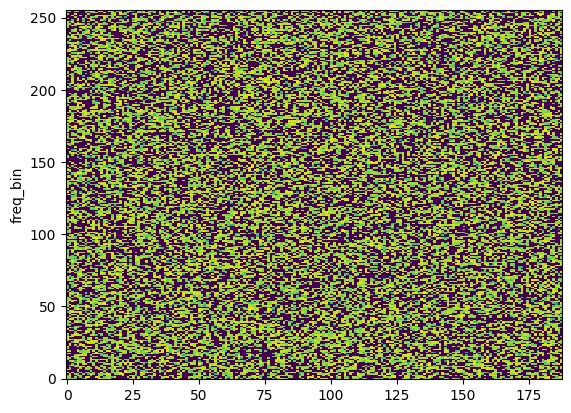

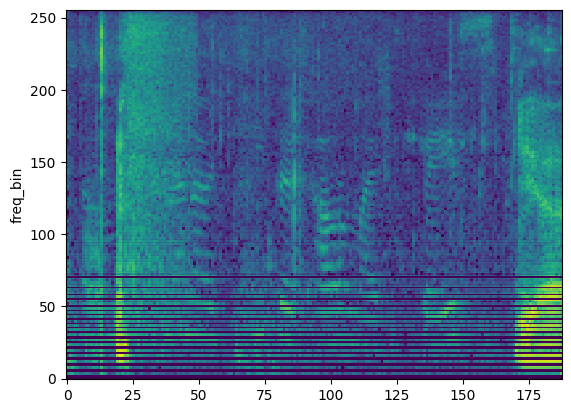

In [21]:
plot_spectrogram(outputs[0][0].detach().cpu())
plot_spectrogram(clean[0][0].detach().cpu())

## KAN Conv

In [10]:
class SeparationConvKAN(nn.Module):
    def __init__(self, n_mels=128, time_steps=188, latent_dim=32):
        super().__init__()

        self.time_steps = time_steps

        # Encoder: Temporal Feature Extraction
        self.encoder = nn.Sequential(
            nn.Conv1d(n_mels, 128, kernel_size=3, padding=1),  # [batch, 256, 188]
            nn.GELU(),
            nn.Conv1d(128, 32, kernel_size=3, stride=2, padding=1),  # [batch, 512, 94]
            nn.GELU(),
        )

        self.enc_time_steps = time_steps // 2
        
        # KAN-based Latent Processing
        self.kan = KAN(width=[32 * self.enc_time_steps, 32, latent_dim], auto_save=False, symbolic_enabled=False)
        
        def make_decoder():
            return nn.Sequential(
                nn.ConvTranspose1d(latent_dim // 2, 64, kernel_size=self.time_steps, stride=1),
                nn.GELU(),
                nn.Conv1d(64, n_mels, kernel_size=3, padding=1)
            )

        # Decoder: Temporal Reconstruction
        self.decoder = nn.ModuleDict({
            'source1': make_decoder(),
            'source2': make_decoder()
        })

    def forward(self, x):
        # Input: [batch, 1, n_mels, time_steps]
        x = x.squeeze(1)  # [batch, n_mels=128, time=188]
        
        # Temporal Encoding
        x = self.encoder(x)  # [batch, 512, 94]
        batch_size = x.shape[0]
        
        # KAN Processing
        x_flat = x.view(batch_size, -1)
        latent = self.kan(x_flat)
        latent1, latent2 = torch.chunk(latent, 2, dim=1)
        # print('latent', latent1.shape, latent2.shape)
        # Temporal Decoding
        out1 = self.decoder['source1'](latent1.unsqueeze(-1))  # [batch, 128, 188]
        out2 = self.decoder['source2'](latent2.unsqueeze(-1))
        # print('out', out1.shape, out2.shape)

        return torch.stack([out1, out2], dim=1)


In [11]:
# Update model initialization
print(dataset.pairs[0][0].shape)
model = SeparationConvKAN(*dataset.pairs[0][0].shape)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
criterion = PermutationInvariantLoss()

print('Starting Training')
# Training loop
for epoch in range(5):
    epoch_loss = 0
    for mixed, clean in tqdm(train_loader):
        # print(mixed.shape, clean.shape)
        # mixed = mixed.to(device)
        # clean = clean.to(device)
        optimizer.zero_grad()
        outputs = model(mixed)
        # print(outputs.shape)
        loss = criterion(outputs, clean)
        # print(loss)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    print(f"Epoch {epoch+1}, Loss: {epoch_loss/len(train_loader):.4f}")


torch.Size([256, 188])
Starting Training


100%|██████████| 32/32 [00:23<00:00,  1.38it/s]


Epoch 1, Loss: 0.0511


100%|██████████| 32/32 [00:21<00:00,  1.51it/s]


Epoch 2, Loss: 0.0115


100%|██████████| 32/32 [00:21<00:00,  1.46it/s]


Epoch 3, Loss: 0.0084


100%|██████████| 32/32 [00:20<00:00,  1.54it/s]


Epoch 4, Loss: 0.0085


100%|██████████| 32/32 [00:20<00:00,  1.57it/s]

Epoch 5, Loss: 0.0082


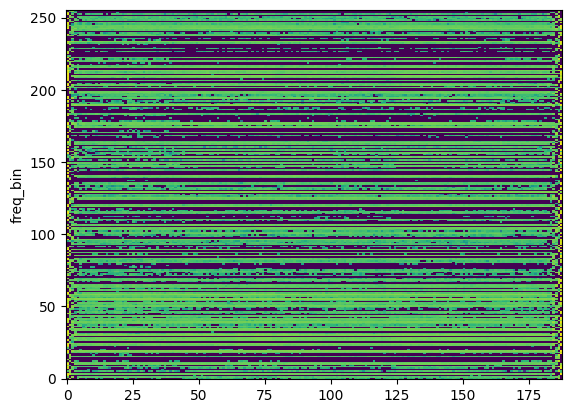

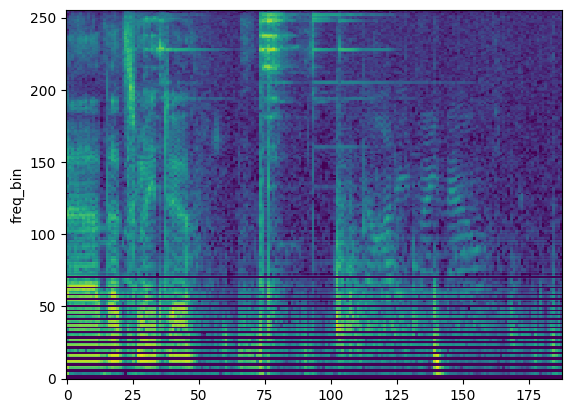

In [12]:
plot_spectrogram(outputs[0][0].detach().numpy())
plot_spectrogram(clean[0][0])

## COnvTasNet with spectrogram input

In [63]:
import torch
import torch.nn as nn

class SimpleConvBlock(nn.Module):
    def __init__(self, io_channels, hidden_channels, kernel_size=3):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(io_channels, hidden_channels, kernel_size, padding="same"),
            nn.PReLU(),
            nn.GroupNorm(1, hidden_channels),
            nn.Conv1d(hidden_channels, io_channels, kernel_size, padding="same"),
            nn.PReLU(),
            nn.GroupNorm(1, io_channels)
        )
        
    def forward(self, x):
        return x + self.conv(x)  # Residual connection

class MelConvTasNet(nn.Module):
    def __init__(self, n_mels=256, num_sources=2, enc_kernel_size=8, enc_feats=256):
        super().__init__()
        # Encoder now accepts n_mels input channels
        self.encoder = nn.Conv1d(n_mels, enc_feats, enc_kernel_size, 
                               stride=enc_kernel_size//2, padding=0)
        
        # Mask Generator remains similar
        self.mask_net = nn.Sequential(
            *[SimpleConvBlock(enc_feats, 512) for _ in range(6)],
            nn.Conv1d(enc_feats, num_sources*enc_feats, 1),
            nn.Softmax(dim=1)
        )
        
        # Modified decoder for spectrogram reconstruction
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(enc_feats, n_mels, enc_kernel_size, 
                             stride=enc_kernel_size//2),
            nn.ReLU()
        )

    def forward(self, x):
        encoded = self.encoder(x)  # Input shape [B, n_mels, T]
        masks = self.mask_net(encoded)
        masks = masks.view(masks.shape[0], -1, self.encoder.out_channels, masks.shape[-1])
        
        separated = encoded.unsqueeze(1) * masks
        return torch.stack([self.decoder(separated[:,i]) for i in range(separated.shape[1])], dim=1)



In [64]:
class SpectralLoss(nn.Module):
    def __init__(self, epsilon=1e-8):
        super().__init__()
        self.epsilon = epsilon

    def forward(self, est, target):
        # Input shapes: [B, n_mels, time_steps]
        numerator = torch.norm(target - est, p='fro', dim=(1,2))
        denominator = torch.norm(target, p='fro', dim=(1,2)) + self.epsilon
        return (numerator / denominator).mean()

class PermutationInvariantSpectralLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.spectral_loss = SpectralLoss()

    def forward(self, outputs, targets):
        """
        Args:
            outputs: [B, num_sources, n_mels, T]
            targets: [B, num_sources, n_mels, T]
        """
        # Calculate both permutations
        loss_0_1 = (self.spectral_loss(outputs[:,0], targets[:,0]) + 
                   self.spectral_loss(outputs[:,1], targets[:,1]))
        
        loss_1_0 = (self.spectral_loss(outputs[:,0], targets[:,1]) + 
                   self.spectral_loss(outputs[:,1], targets[:,0]))
        
        return torch.min(loss_0_1, loss_1_0)


In [67]:
# Update model initialization
print(dataset.pairs[0][0].shape)
model = MelConvTasNet()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
criterion = PermutationInvariantLoss()

print('Starting Training')
# Training loop
for epoch in range(5):
    epoch_loss = 0
    for mixed, clean in tqdm(train_loader):
        # print(mixed.shape, clean.shape)
        # mixed = mixed.to(device)
        # clean = clean.to(device)
        optimizer.zero_grad()
        outputs = model(mixed)
        # print(outputs.shape)
        loss = criterion(outputs, clean)
        # print(loss)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    print(f"Epoch {epoch+1}, Loss: {epoch_loss/len(train_loader):.4f}")


Starting Training


  0%|          | 0/2 [00:00<?, ?it/s]


RuntimeError: Given groups=1, weight of size [256, 48000, 8], expected input[1, 64, 48000] to have 48000 channels, but got 64 channels instead

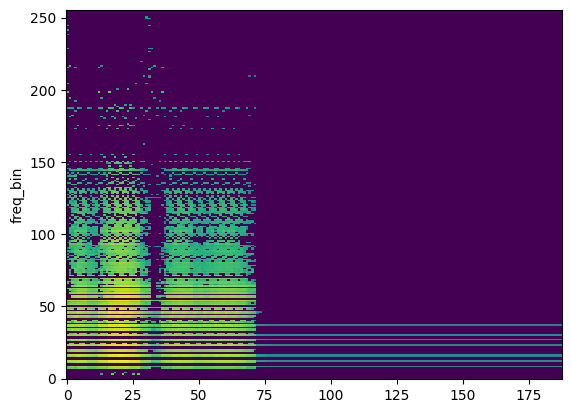

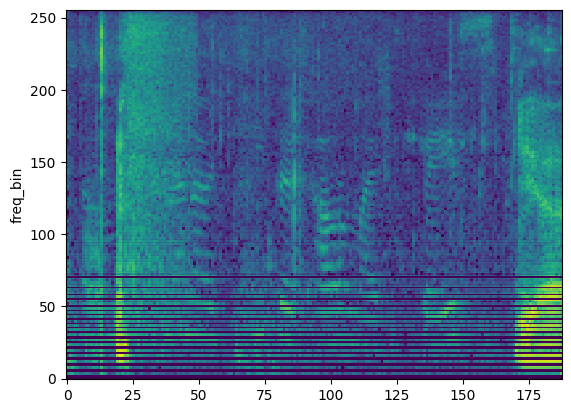

In [60]:
plot_spectrogram(outputs[0][0].detach().cpu().numpy())
plot_spectrogram(clean[0][0].detach().cpu().numpy())

## ConvTasNet with audio wave

In [59]:
dataset = DiPCoSeparationDataset(
    root_dir='./data/Dipco/',
    session_ids=['S02'],#, 'S04', 'S05', 'S09', 'S10'],
    sr=8000,
    segment_length=4,
    max_pairs=100000,
    transform=False
)
train_loader = DataLoader(dataset, batch_size=16, shuffle=True)
len(dataset.pairs), dataset.pairs[0][0].shape, dataset.pairs[0][1].shape, len(train_loader)

Loading S02, unique speaker_ids: dict_keys(['P05', 'P06', 'P07', 'P08'])


(100000, torch.Size([1, 32000]), torch.Size([2, 1, 32000]), 6250)

In [60]:
import torch
import torch.nn as nn

class SimpleConvBlock(nn.Module):
    def __init__(self, io_channels, hidden_channels, kernel_size=3):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(io_channels, hidden_channels, kernel_size, padding="same"),
            nn.PReLU(),
            nn.GroupNorm(1, hidden_channels),
            nn.Conv1d(hidden_channels, io_channels, kernel_size, padding="same"),
            nn.PReLU(),
            nn.GroupNorm(1, io_channels)
        )
        
    def forward(self, x):
        return x + self.conv(x)  # Residual connection

class SimpleConvTasNet(nn.Module):
    def __init__(self, enc_kernel_size=16, enc_feats=512, mask_hidden=512, mask_num_layers=6):
        super().__init__()
        # Encoder: [B, 1, T] -> [B, F, T']
        self.encoder = nn.Conv1d(1, enc_feats, enc_kernel_size, 
                               stride=enc_kernel_size//2, padding=0)
        
        # Mask Generator
        self.mask_net = nn.Sequential(
            *[SimpleConvBlock(enc_feats, mask_hidden) for _ in range(mask_num_layers)],
            nn.Conv1d(enc_feats, 2*enc_feats, 1),
            nn.Softmax(dim=1)
        )

        # Decoder: [B, F, T'] -> [B, 1, T]
        self.decoder = nn.ConvTranspose1d(enc_feats, 1, enc_kernel_size,
                                        stride=enc_kernel_size//2)

    def forward(self, x):
        # x shape: [B, 1, T]
        encoded = self.encoder(x)
        masks = self.mask_net(encoded)
        masks = masks.view(masks.shape[0], 2, -1, masks.shape[-1])
        
        separated = encoded.unsqueeze(1) * masks
        return torch.cat([self.decoder(separated[:,i]) for i in range(2)], dim=1)



In [61]:
class PermutationInvariantSISNRLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.eps = 1e-8

    def _si_snr(self, estimates, targets):
        # estimates: [B, T]
        # targets: [B, T]
        estimates = estimates - estimates.mean(dim=-1, keepdim=True)
        targets = targets - targets.mean(dim=-1, keepdim=True)

        # Compute SI-SNR
        s_target = (torch.sum(estimates * targets, dim=-1, keepdim=True) * targets) \
                   / (torch.norm(targets, p=2, dim=-1, keepdim=True)**2 + self.eps)
        
        e_noise = estimates - s_target
        return 10 * torch.log10(
            (torch.norm(s_target, p=2, dim=-1)**2 + self.eps) / 
            (torch.norm(e_noise, p=2, dim=-1)**2 + self.eps)
        )

    def forward(self, outputs, targets):
        """
        Args:
            outputs: [B, 2, T] separated waveforms
            targets: [B, 2, T] original clean waveforms
        Returns:
            loss: scalar
        """
        # Compute all permutations
        loss_0 = self._si_snr(outputs[:,0], targets[:,0]) + \
                 self._si_snr(outputs[:,1], targets[:,1])
        
        loss_1 = self._si_snr(outputs[:,0], targets[:,1]) + \
                 self._si_snr(outputs[:,1], targets[:,0])

        # Return negative of best permutation
        return -torch.mean(torch.min(loss_0, loss_1))


In [63]:
# Update model initialization
print(dataset.pairs[0][0].shape)
model = SimpleConvTasNet(enc_feats=16, mask_hidden=16, mask_num_layers=3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# criterion = PermutationInvariantLoss()
criterion  = PermutationInvariantSISNRLoss()

print('Starting Training')
# Training loop
for epoch in range(50):
    epoch_loss = 0
    for s_idx, (mixed, clean) in tqdm(enumerate(train_loader), desc=f'Epoch {epoch + 1}', position=epoch, total=len(train_loader)):
        # print(mixed.shape, clean.shape)
        mixed = mixed.to(device)
        clean = clean.to(device)
        optimizer.zero_grad()
        outputs = model(mixed)
        # print(outputs.shape)
        loss = criterion(outputs, clean)
        if s_idx % 1000 == 0:
            print(loss)
        # print(loss.item())
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    print(f"Epoch {epoch+1}, Loss: {epoch_loss/len(train_loader):.4f}")
    checkpoint_path = f'./models/simple_convtasnet_epoch{epoch+1}.pth'
    torch.save(model.state_dict(), checkpoint_path)
    print(f"Saved model checkpoint to {checkpoint_path}")


torch.Size([1, 32000])
Starting Training


Epoch 1:   0%|          | 0/6250 [00:00<?, ?it/s]

tensor(127.9555, device='cuda:0', grad_fn=<NegBackward0>)


Epoch 1:  16%|█▌        | 1003/6250 [01:03<05:33, 15.73it/s]

tensor(26.9921, device='cuda:0', grad_fn=<NegBackward0>)


Epoch 1:  32%|███▏      | 2003/6250 [02:09<04:32, 15.59it/s]

tensor(0.1648, device='cuda:0', grad_fn=<NegBackward0>)


Epoch 1:  48%|████▊     | 3003/6250 [03:13<03:21, 16.08it/s]

tensor(0.0673, device='cuda:0', grad_fn=<NegBackward0>)


Epoch 1:  64%|██████▍   | 4001/6250 [04:19<02:57, 12.65it/s]

tensor(0.0269, device='cuda:0', grad_fn=<NegBackward0>)


Epoch 1:  80%|████████  | 5003/6250 [05:24<01:18, 15.80it/s]

tensor(0.2247, device='cuda:0', grad_fn=<NegBackward0>)


Epoch 1:  96%|█████████▌| 6003/6250 [06:29<00:16, 15.27it/s]

tensor(0.0068, device='cuda:0', grad_fn=<NegBackward0>)


Epoch 1: 100%|██████████| 6250/6250 [06:44<00:00, 15.43it/s]


Epoch 1, Loss: 11.5792
Saved model checkpoint to ./models/simple_convtasnet_epoch1.pth


tensor(0.0057, device='cuda:0', grad_fn=<NegBackward0>)


tensor(0.0039, device='cuda:0', grad_fn=<NegBackward0>)


tensor(0.0088, device='cuda:0', grad_fn=<NegBackward0>)


tensor(0.0005, device='cuda:0', grad_fn=<NegBackward0>)


tensor(0.0008, device='cuda:0', grad_fn=<NegBackward0>)


tensor(0.0004, device='cuda:0', grad_fn=<NegBackward0>)


tensor(0.0001, device='cuda:0', grad_fn=<NegBackward0>)


Epoch 2: 100%|██████████| 6250/6250 [06:40<00:00, 15.60it/s]


Epoch 2, Loss: 0.0046
Saved model checkpoint to ./models/simple_convtasnet_epoch2.pth


tensor(8.1384e-05, device='cuda:0', grad_fn=<NegBackward0>)


tensor(5.9214e-05, device='cuda:0', grad_fn=<NegBackward0>)


tensor(1.5176e-05, device='cuda:0', grad_fn=<NegBackward0>)


tensor(1.7489e-05, device='cuda:0', grad_fn=<NegBackward0>)


tensor(9.4646e-06, device='cuda:0', grad_fn=<NegBackward0>)


tensor(3.4299e-06, device='cuda:0', grad_fn=<NegBackward0>)


tensor(6.0023e-06, device='cuda:0', grad_fn=<NegBackward0>)






























































































































Epoch 3: 100%|██████████| 6250/6250 [06:39<00:00, 15.63it/s]


Epoch 3, Loss: 0.0001
Saved model checkpoint to ./models/simple_convtasnet_epoch3.pth







Epoch 4:   0%|          | 2/6250 [00:00<07:16, 14.30it/s]

tensor(8.8336e-06, device='cuda:0', grad_fn=<NegBackward0>)


tensor(1.8282e-06, device='cuda:0', grad_fn=<NegBackward0>)


tensor(2.0223e-06, device='cuda:0', grad_fn=<NegBackward0>)


tensor(5.5008e-07, device='cuda:0', grad_fn=<NegBackward0>)


tensor(4.2065e-07, device='cuda:0', grad_fn=<NegBackward0>)


tensor(0.0001, device='cuda:0', grad_fn=<NegBackward0>)


tensor(3.7211e-07, device='cuda:0', grad_fn=<NegBackward0>)


























































































































































































































































Epoch 4: 100%|██████████| 6250/6250 [06:39<00:00, 15.63it/s]


Epoch 4, Loss: 0.0001
Saved model checkpoint to ./models/simple_convtasnet_epoch4.pth


tensor(6.4715e-08, device='cuda:0', grad_fn=<NegBackward0>)


tensor(-0., device='cuda:0', grad_fn=<NegBackward0>)


tensor(9.7072e-08, device='cuda:0', grad_fn=<NegBackward0>)


tensor(3.2357e-07, device='cuda:0', grad_fn=<NegBackward0>)


tensor(-0., device='cuda:0', grad_fn=<NegBackward0>)


tensor(-0., device='cuda:0', grad_fn=<NegBackward0>)


tensor(-0., device='cuda:0', grad_fn=<NegBackward0>)

































































































































































Epoch 5:  98%|█████████▊| 6109/6250 [06:53<00:09, 14.78it/s]


KeyboardInterrupt: 

In [65]:
for mixed, clean in tqdm(train_loader, desc=f'Epoch {epoch + 1}'):
        # print(mixed.shape, clean.shape)
        mixed = mixed.to(device)
        clean = clean.to(device)
        model.eval()
        outputs = model(mixed)
        break

outputs.shape, outputs[0][0].shape

Epoch 5:   0%|          | 0/6250 [00:00<?, ?it/s]


(torch.Size([16, 2, 32000]), torch.Size([32000]))

In [66]:
outputs[0][0].cpu().detach().shape, clean[0][0].cpu().detach().shape

(torch.Size([32000]), torch.Size([1, 32000]))

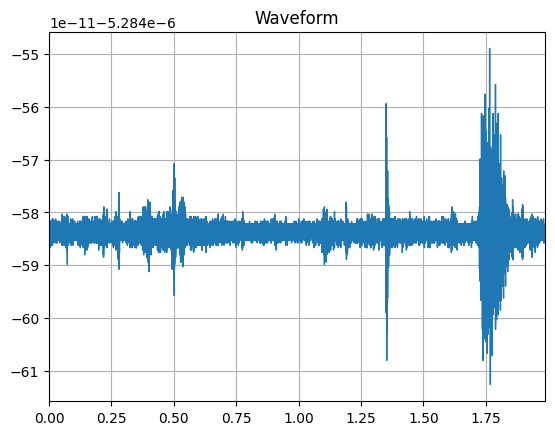

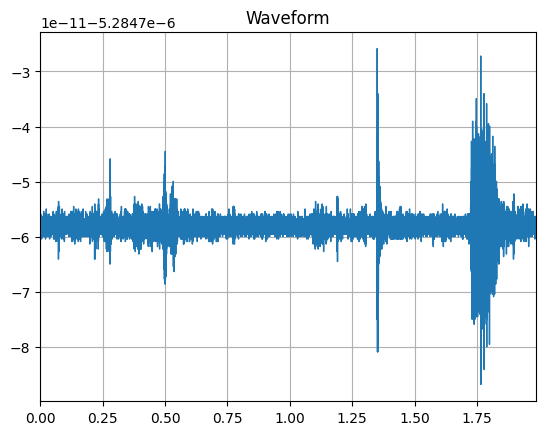

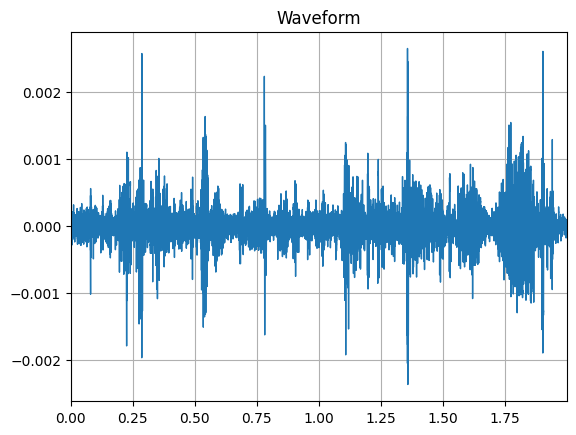

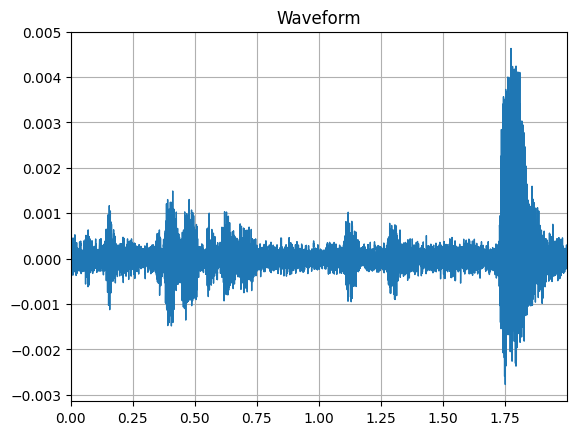

In [67]:
plot_waveform((outputs[0][0].cpu().detach()[100:-100]).unsqueeze(0), sr=16000)
plot_waveform((outputs[0][1].cpu().detach()[100:-100]).unsqueeze(0), sr=16000)
plot_waveform(clean[0][0].cpu().detach(), sr=16000)
plot_waveform(clean[0][1].cpu().detach(), sr=16000)

In [73]:
import torchaudio

def save_wave(tensor, sample_rate, filepath):
    """
    Save a PyTorch tensor as a .wav file.
    
    Args:
        tensor (Tensor): Audio tensor of shape [1, time] or [channels, time]
        sample_rate (int): Sampling rate (e.g., 16000)
        filepath (str): Output file path ending in .wav
    """
    # Ensure it's 2D (channels, time)
    if tensor.dim() == 1:
        tensor = tensor.unsqueeze(0)
    
    torchaudio.save(filepath, tensor.cpu(), sample_rate)
    print(f"Saved WAV file to {filepath}")

save_wave(clean[0][0].cpu().detach(), sample_rate=8000, filepath="output.wav")

Saved WAV file to output.wav
